In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from qiskit import *
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, RealAmplitudes, ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.circuit.library import CCXGate, CRZGate, RXGate
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.primitives import Sampler
from qiskit.circuit import ParameterVector
from sklearn.metrics import recall_score, precision_score, f1_score
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
import os

In [2]:
df_train=pd.read_csv("../data/train_fe_small.csv")
#df_test=pd.read_csv("../data/milk_test_fe.csv")

In [3]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.savefig(vqc_num)
    plt.show()
    
def callback_res(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print(objective_func_vals)
    return objective_func_vals

In [4]:
sampler = Sampler()
#optimizer = COBYLA(maxiter = 300)
#optimizer = SPSA(maxiter = 300)

X_train = df_train.drop(columns=['grade'])
y_train = df_train['grade']

X_val = df_val.drop(columns=['grade'])
y_val = df_val['grade']

x_train_arr = np.array(X_train)
x_val_arr = np.array(X_val)

y_train=y_train.to_numpy()
y_val = y_val.to_numpy()

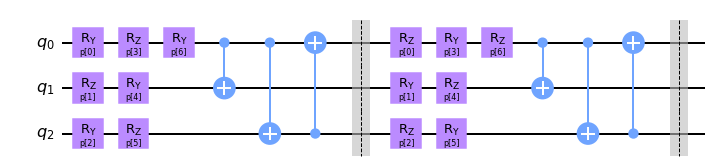

In [5]:
from qiskit.circuit import ParameterVector, Parameter

### Feature map
pauli_feature_map = PauliFeatureMap(feature_dimension=len(X_train.columns), reps=1)

### Ansatzes
ansatz_su = EfficientSU2(num_qubits=pauli_feature_map.width(), reps = 2, su2_gates=["ry", "rz"], entanglement= "full",
                         insert_barriers=True)
ansatz_two_local = TwoLocal(num_qubits=pauli_feature_map.width(),rotation_blocks=["ry", "rz"],entanglement_blocks="cx",
                                     entanglement="linear", reps=2, insert_barriers=True)

theta = Parameter("θ")
ansatz_n_local = NLocal(num_qubits=pauli_feature_map.width(),rotation_blocks=[RXGate(theta), CRZGate(theta)],
                        entanglement_blocks=CCXGate(),
                        entanglement=[[0, 1, 2], [0,2,1]],reps=2,insert_barriers=True)

In [ ]:
### Optimizers
num_iter=300
cobyla = COBYLA(maxiter = num_iter)
spsa = SPSA(maxiter = num_iter)


In [12]:
vqc_mod = VQC.load("../vqc_model/custom/mod_1.model")

In [13]:
vqc_mod.weights

array([0.12134705, 0.21561862, 3.39084615, 0.98922863, 2.937299  ,
       0.82210415, 0.55495745, 0.50293151, 0.56535374, 0.72213926,
       1.99984971, 0.67257757])

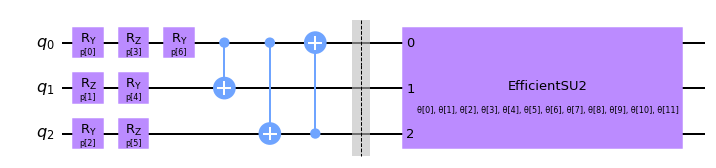

In [14]:
vqc_mod.circuit.draw("mpl")

In [15]:
cb = vqc_mod.callback

In [16]:
def plot_confusion_matrix(conf_matrix):
    num = len(os.listdir("conf_matrix"))
    conf_num = "conf_matrix/conf" + str(num) + ".png"
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(conf_num)
    plt.show()

In [17]:
def vqc_exp(ansatz, optimizer):
    
    if optimizer == "cobyla":
        optim_use = cobyla
    elif optimizer == "spsa":
        optim_use = spsa
        
    if ansatz == "su2":
        ansatz_use = ansatz_su
    elif ansatz == "two_local":
        ansatz_use = ansatz_two_local
    elif ansatz == "n_local":
        ansatz_use = ansatz_n_local
        
    #objective_func_vals = []
    objective_func_vals = []
    
    def callback_res(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals.append(obj_func_eval)
        print(objective_func_vals)
        return objective_func_vals
    
    print("===="*20)
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz_use,
        optimizer=optim_use,
        callback=callback_res,
    )

    start = time.time()
    vqc.fit(x_train_arr, y_train)
    elapsed = time.time() - start

    num = len(os.listdir("../vqc_model/custom"))
    vqc_mod_num = "../vqc_model/custom/mod_" + str(num) + ".model"
    vqc.save(vqc_mod_num)

    print(f"Training time: {round(elapsed)} seconds")

    train_score = vqc.score(x_train_arr, y_train)
    test_score = vqc.score(x_test_arr, y_test)

    #vqc.save("vqc_enc_classifier.model")

    print(f"VQC Enc on the training dataset: {train_score:.2f}")
    print(f"VQC Enc on the test dataset:     {test_score:.2f}")
    
    pred_vqc = vqc.predict(x_test_arr)
    conf_matrix = confusion_matrix(y_test, pred_vqc)

    #plot_confusion_matrix(conf_matrix)
    print(classification_report(y_test, pred_vqc))
    print("\n")

    df = pd.DataFrame({"one":[1]})

    df["feature_map_type"] = "Custom"
    df["optimizer"] = optimizer
    df["train_score"] = train_score
    df["test_score"] = test_score
    df["recall_score"] = recall_score(y_test, pred_vqc,average='weighted')
    df["f1_score"] = f1_score(y_test, pred_vqc, average='weighted')
    df["precision_score"] = precision_score(y_test, pred_vqc, average='weighted')
    #df["Quantum Kernel"] = "No"
    #df["PCA"] = "No"
    df["objective_vals"] = str(objective_func_vals)
    df["Ansatz"] = ansatz
    df["Training time"] = elapsed
    df["Model"] = "VQC"
    df["Max Iter"] = num_iter

    df = df.drop("one", axis = 1)

    num = len(os.listdir("../vqc_results/custom"))
    #df.to_csv("../vqc_results/custom/res_" + str(num) + ".csv", index = False)
    # clear objective value history
    #objective_func_vals = []
    return df

In [18]:
ret = vqc_exp("su2","cobyla")

[1.470252900787418, 1.70021314823339, 1.7056039025688252, 1.2978525962529477, 1.283734536573476, 1.2509978816075282, 1.2733823652915695, 1.3597513986471792, 1.3001617299990735, 1.3132588929661786, 1.250997881607528, 1.2509978816075278, 1.250997881607528, 1.4432741979160852, 1.317590789267797, 1.286608509846809, 1.4635195421310323, 1.2839474678531029, 1.2969724566643364, 1.2098979627897148]
Training time: 102 seconds
VQC Enc on the training dataset: 0.64
VQC Enc on the test dataset:     0.63
              precision    recall  f1-score   support

         0.0       0.62      0.74      0.67        43
         1.0       0.73      0.81      0.77        37
         2.0       0.38      0.19      0.26        26

    accuracy                           0.63       106
   macro avg       0.58      0.58      0.57       106
weighted avg       0.60      0.63      0.60       106





In [19]:
ret

,feature_map_type,optimizer,train_score,test_score,recall_score,f1_score,precision_score,objective_vals,Ansatz,Training time,Model,Max Iter
0,Custom,cobyla,0.643232,0.632075,0.632075,0.604685,0.599384,"[1.470252900787418, 1.70021314823339, 1.705603...",su2,102.205603,VQC,20


In [20]:
ret2 = vqc_exp("su2","spsa")

[1.8002354911557317, 1.7816243471040571, 1.9294368911454782, 1.7154362552643043, 1.75585095739946, 1.8172516570849178, 1.7403298115054966, 1.76887610514183, 1.746385882433616, 1.9359618320902166, 1.7449051469600831, 1.9216683715410023, 1.6669904765873897, 1.965540167636062, 1.6776393761324693, 1.9701281498353782, 1.755058606257511, 1.7647484038138181, 1.7365234172711705, 1.9279305413580337, 1.9588366882119153, 1.7091382213859787, 1.7330957120952297, 1.934551741485313, 1.7925743980541637, 1.8313710404287449, 1.7302811213437783, 1.7788488324012146, 1.794623053776945, 1.7967707654190908, 1.7608797821263094, 1.718409278717148, 1.7798281212635072, 1.823917370767823, 1.9229022320076017, 1.7069455492321775, 1.9538603460568333, 1.6847538979127665, 1.7798095452945466, 1.9130747318445618, 1.7211735679315532, 1.913882809127884, 1.8123290270248291, 1.7651664569403815, 1.7365234172711705, 1.9279305413580337, 1.9812891936380874, 1.6682550346541183, 1.7252561516526799, 1.9493399195581973, 1.841581564

/home/ganiyuma/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ganiyuma/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ganiyuma/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ganiyuma/.local/lib/python3.

In [21]:
ret2

,feature_map_type,optimizer,train_score,test_score,recall_score,f1_score,precision_score,objective_vals,Ansatz,Training time,Model,Max Iter
0,Custom,spsa,0.543547,0.518868,0.518868,0.450214,0.416085,"[1.8002354911557317, 1.7816243471040571, 1.929...",su2,453.618424,VQC,20
